# Auto-cross-correlogram

In [105]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import scipy.signal as signal
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy import stats

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase

one = ONE()

## Parameters

In [106]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [109]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]
    
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    # design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    
    # Keep only first 90 trials
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [48]:
a = session_trials.copy()
a['trial_duration'] = a['intervals_1'] - a['intervals_0']

(0.0, 10.0)

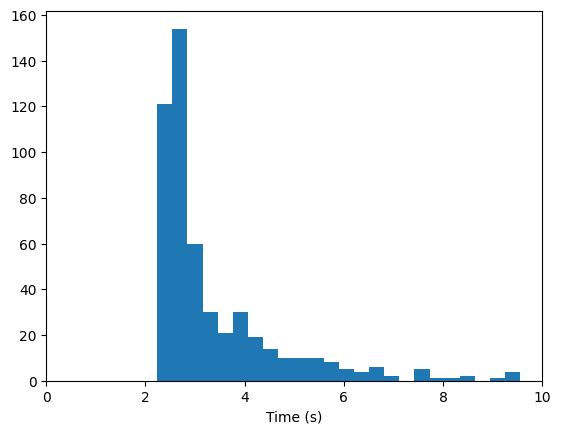

In [49]:
plt.hist(a['trial_duration'], bins=200)
plt.xlabel('Time (s)')
plt.xlim([0, 10])

## Auto-correlation

In [110]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

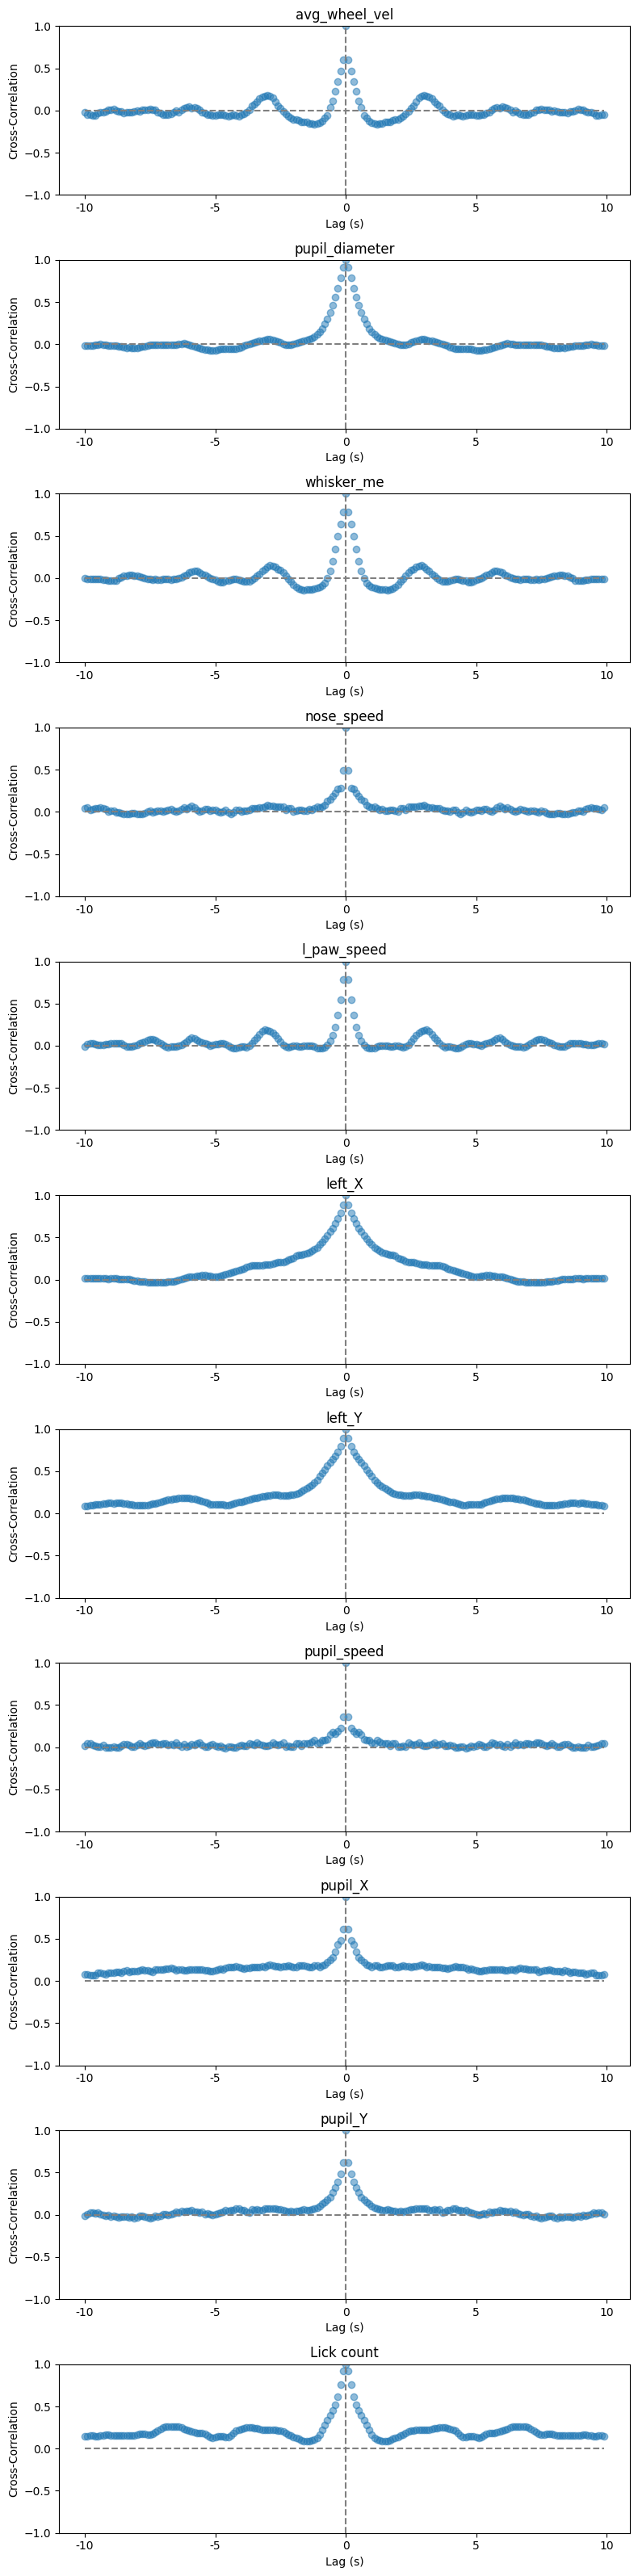

Text(0.5, 0, 'Time lag (s)')

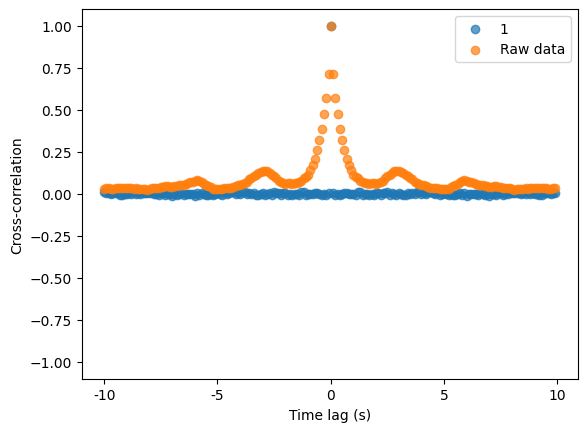

In [113]:
features = use_data.keys()
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# features = ['left_Y', 'left_X']

lags_to_plot = 100

chunk_sizes = [1, 2, 5, 10]
chunk_sizes = [1, 5]
chunk_sizes = [1]

for c, chunk_size in enumerate(chunk_sizes):

    # Split the DataFrame into chunks
    chunks = [use_data.iloc[i:i + chunk_size] for i in range(0, len(use_data), chunk_size)]
    # # Shuffle each chunk independently
    # shuffled_chunks = [chunk.sample(frac=1) for chunk in chunks]
    # # Concatenate the shuffled chunks back together
    # shuffled_data = pd.concat(shuffled_chunks, ignore_index=True)

    
    shuffle_idx = np.random.permutation(np.array(chunks).shape[0])
    a = np.array(chunks)[shuffle_idx]
    b = a.reshape((np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2]))
    shuffled_data = pd.DataFrame(b)

    corrs = []
    corrs_shuf = []

    if c == 0:
        fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])    
        # fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 5])   
         
    for i, pc in enumerate(features):
        
        x = use_data[pc]
        x_shuf = shuffled_data[i]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        cross_correlation_shuf = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])
                
                x_chunk_shuf = np.array(x_shuf[-lag:])
                y_chunk_shuf = np.array(x_shuf[:lag])            
                
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

                x_chunk_shuf = np.array(x_shuf)
                y_chunk_shuf = np.array(x_shuf)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
                x_chunk_shuf = np.array(x_shuf[0:-lag])
                y_chunk_shuf = np.array(x_shuf[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            cross_correlation_shuf[l] = stats.pearsonr(x_chunk_shuf, y_chunk_shuf).statistic
            
        # Save data
        if i == 0:
            corrs = [cross_correlation]
            corrs_shuf = [cross_correlation_shuf]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            corrs_shuf = np.vstack((corrs_shuf, cross_correlation_shuf))
           
        # Plot the cross-correlation once 
        if c == 0:
            #ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data', alpha=0.5)    
            ax[i].scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
            ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
            ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
            ax[i].set_xlabel('Lag (s)')
            ax[i].set_ylabel('Cross-Correlation')
            ax[i].set_title(pc)
            ax[i].set_ylim([-1, 1])
            ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])

                    
            plt.tight_layout()
plt.show()
    
plt.scatter(lags, np.mean(corrs_shuf, axis=0), alpha=0.7, label=str(chunk_size))    
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-1.1, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
# Add labels and legend
plt.xlabel('Time lag (s)')
#plt.xlim([0, 35])


Text(0, 0.5, 'Paw Y position')

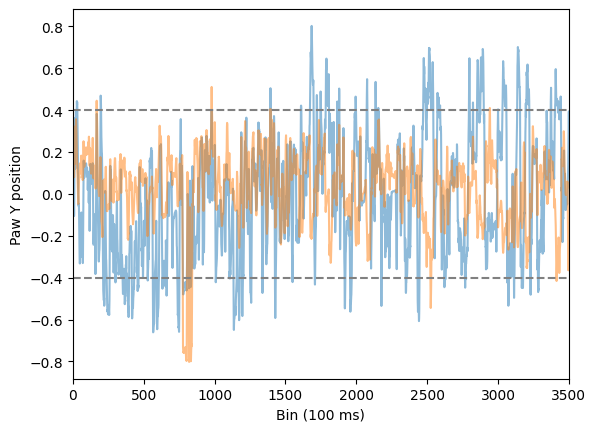

In [116]:
plt.plot(use_data['left_Y'].rolling(window=5).mean(), alpha=0.5)
plt.plot(use_data['left_X'].rolling(window=5).mean(), alpha=0.5)
plt.hlines(0.4, 0, 3500, linestyles='--', color='Gray')
plt.hlines(-0.4, 0, 3500, linestyles='--', color='Gray')
plt.xlim([0, 3500])
plt.xlabel('Bin (100 ms)')
plt.ylabel('Paw Y position')

## Fit tau

The rate at which this autocorrelogram declines in a behaving mouse may be characterized as a time-constant, tau, of an exponentially decaying curve. Tau was fit using the Levenberg-Marquardt algorithm (non-linear least squares) using the SciPy optimization package.

2.3
6.3
3.0
1.9
2.5
13.8
8.3
1.2
2.2
3.2
3.4


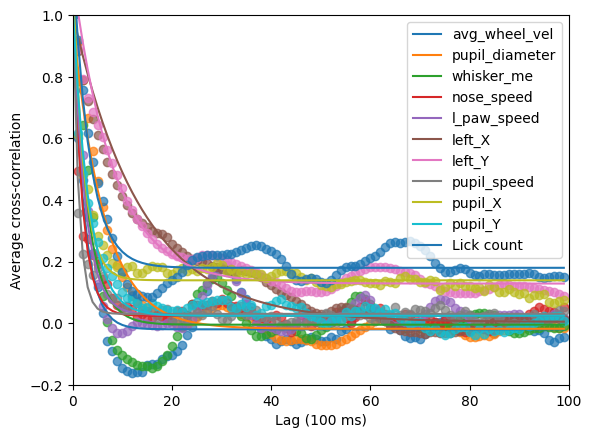

In [121]:
def func(t, tau, c):
    return np.exp(-t / tau) + c



for v, var in enumerate(range(np.shape(corrs)[0])):
    end = 1000
    t = lags[lags_to_plot:end]
    y = corrs[v, lags_to_plot:end]


    popt, pcov = curve_fit(func, t, y)

    tau, c = popt
    y_fit = func(t, tau, c)
    
    plt.scatter(lags[lags_to_plot:end], y, alpha=0.7)
    plt.plot(lags[lags_to_plot:end], y_fit, label=features[var])
    #plt.legend(str(np.round(tau, decimals=1)))
    plt.legend()
    print(np.round(tau, decimals=1))

    plt.ylim([-.2, 1])
    plt.xlabel('Lag (100 ms)')
    plt.ylabel('Average cross-correlation')
    plt.xlim([0, lags_to_plot])
    

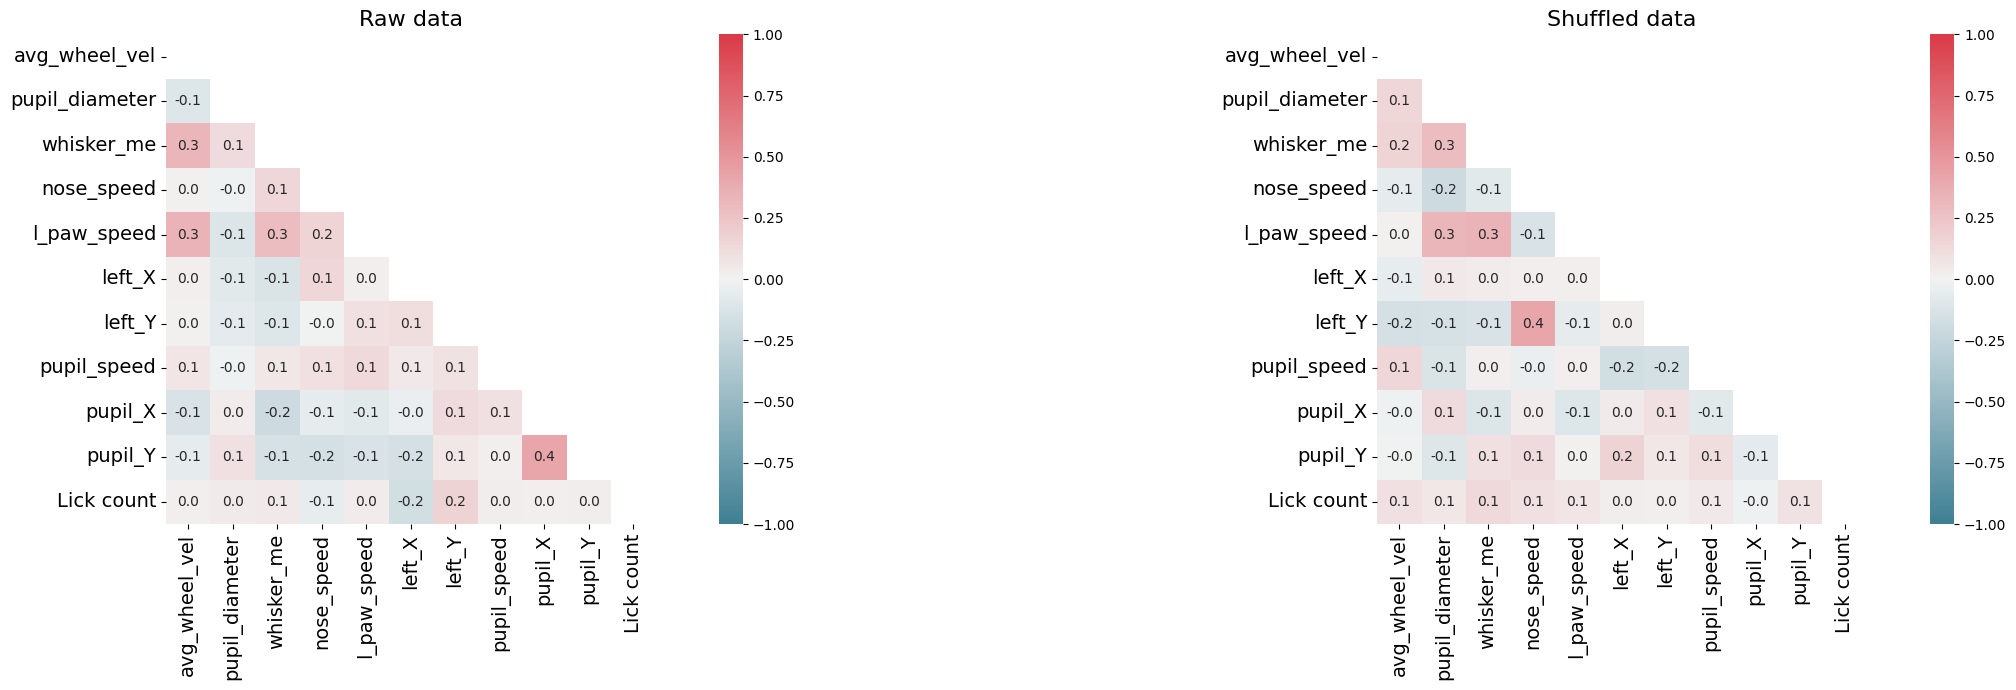

In [136]:

fig, ax = plt.subplots(nrows=1, ncols=2 , sharex=False, sharey=False, figsize=[25, 7])
plt.rc('font', size=10)

cov_df = use_data[var_names].dropna().drop_duplicates()
cov = cov_df.corr()

# f = ax[v].figure(figsize=(10, 11))
ax[0].set_xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
ax[0].set_yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
ax[0].set_title('Raw data', fontsize=16)
matrix = np.triu(cov)

sns.heatmap(cov,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0, fmt=".1f",
    square=True, annot=True, mask=matrix, ax=ax[0])


# Shuffled data

shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well
shuffled_data[np.array(features)] = shuffled_data[np.array(features)].sample(frac=1, axis=0).sample(frac=1, axis=1)  # Shuffle both rows and columns


cov_df = shuffled_data.dropna().drop_duplicates()
cov = cov_df.corr()
ax[1].set_xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
ax[1].set_yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
ax[1].set_title('Shuffled data', fontsize=16)
matrix = np.triu(cov)

sns.heatmap(cov,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0, fmt=".1f",
    square=True, annot=True, mask=matrix, ax=ax[1])


plt.tight_layout()
plt.show()

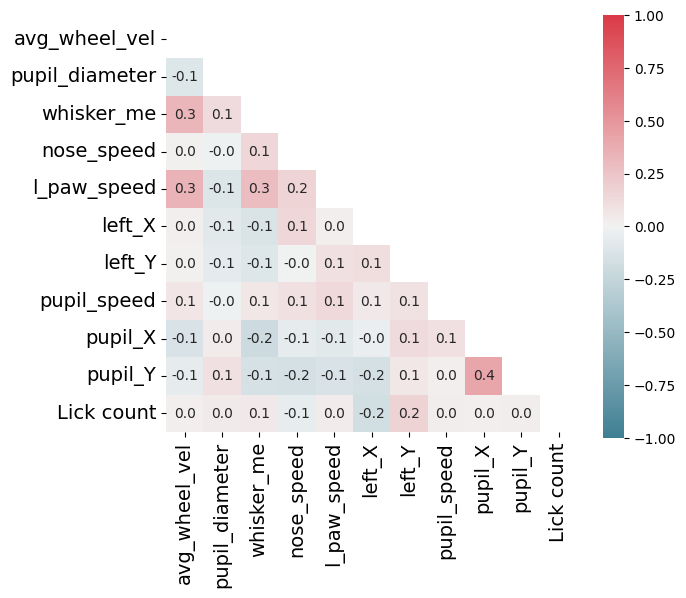

In [127]:
# Session correlation matrix

fig, ax = plt.subplots(figsize=[7, 6])
plt.rc('font', size=10)

cov_df = use_data[var_names].dropna().drop_duplicates()
cov = cov_df.corr()

# f = ax[v].figure(figsize=(10, 11))
plt.xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
plt.yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)

matrix = np.triu(cov)

sns.heatmap(cov,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0, fmt=".1f",
    square=True, annot=True, mask=matrix)

shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well
shuffled_data[np.array(pcs)] = shuffled_data[np.array(pcs)].sample(frac=1, axis=0).sample(frac=1, axis=1)  # Shuffle both rows and columns


plt.tight_layout()
plt.show()

In [ ]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])

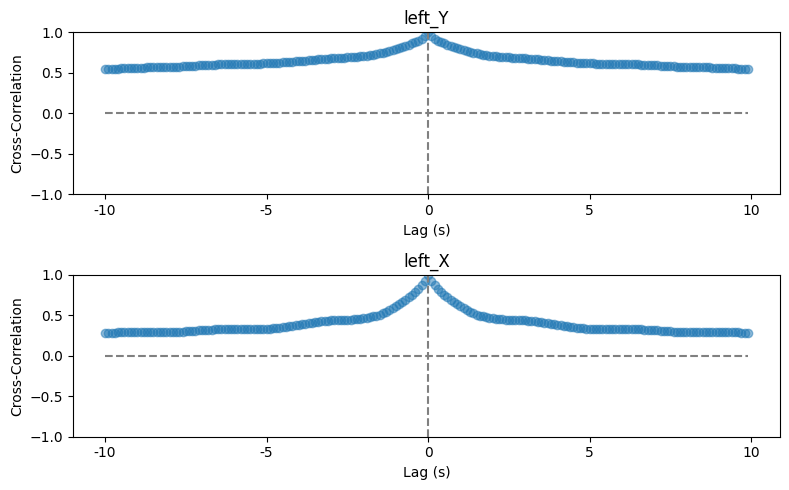

Text(0.5, 0, 'Time lag (s)')

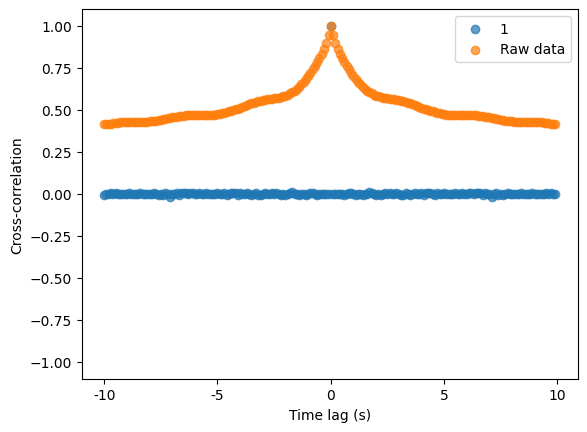

In [ ]:
features = use_data.keys()
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

features = ['left_Y', 'left_X']

lags_to_plot = 100

chunk_sizes = [1, 2, 5, 10]
chunk_sizes = [1, 5]
chunk_sizes = [1]

for c, chunk_size in enumerate(chunk_sizes):

    # Split the DataFrame into chunks
    chunks = [use_data.iloc[i:i + chunk_size] for i in range(0, len(use_data), chunk_size)]
    # # Shuffle each chunk independently
    # shuffled_chunks = [chunk.sample(frac=1) for chunk in chunks]
    # # Concatenate the shuffled chunks back together
    # shuffled_data = pd.concat(shuffled_chunks, ignore_index=True)

    
    shuffle_idx = np.random.permutation(np.array(chunks).shape[0])
    a = np.array(chunks)[shuffle_idx]
    b = a.reshape((np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2]))
    shuffled_data = pd.DataFrame(b)

    corrs = []
    corrs_shuf = []

    if c == 0:
        #fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 32])    
        fig, ax = plt.subplots(nrows=len(features) , ncols=1, sharex=False, sharey=False, figsize=[8, 5])   
         
    for i, pc in enumerate(features):
        
        x = use_data[pc]
        x_shuf = shuffled_data[i]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        cross_correlation_shuf = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])
                
                x_chunk_shuf = np.array(x_shuf[-lag:])
                y_chunk_shuf = np.array(x_shuf[:lag])            
                
            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

                x_chunk_shuf = np.array(x_shuf)
                y_chunk_shuf = np.array(x_shuf)
            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
                x_chunk_shuf = np.array(x_shuf[0:-lag])
                y_chunk_shuf = np.array(x_shuf[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            cross_correlation_shuf[l] = stats.pearsonr(x_chunk_shuf, y_chunk_shuf).statistic
            
        # Save data
        if i == 0:
            corrs = [cross_correlation]
            corrs_shuf = [cross_correlation_shuf]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            corrs_shuf = np.vstack((corrs_shuf, cross_correlation_shuf))
           
        # Plot the cross-correlation once 
        if c == 0:
            #ax[i].scatter(lags, cross_correlation_shuf, label='Shuffled data', alpha=0.5)    
            ax[i].scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
            ax[i].hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
            ax[i].vlines(0, -1, 1, color='gray', linestyles='--')
            ax[i].set_xlabel('Lag (s)')
            ax[i].set_ylabel('Cross-Correlation')
            ax[i].set_title(pc)
            ax[i].set_ylim([-1, 1])
            ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])

                    
            plt.tight_layout()
plt.show()
    
plt.scatter(lags, np.mean(corrs_shuf, axis=0), alpha=0.7, label=str(chunk_size))    
plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
plt.legend()
plt.ylim([-1.1, 1.1])
#plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
# Add labels and legend
plt.xlabel('Time lag (s)')
#plt.xlim([0, 35])


Text(0, 0.5, 'Paw Y position')

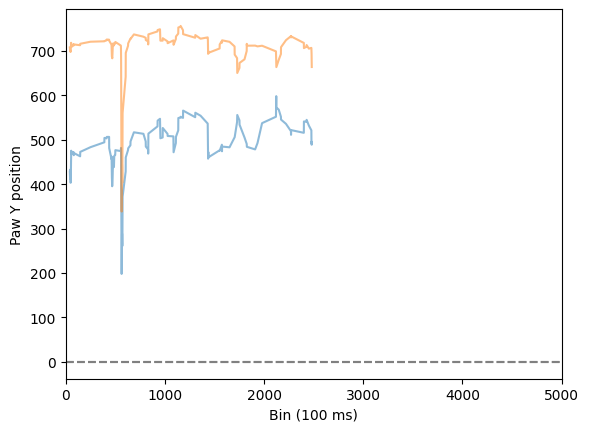

In [ ]:
plt.plot(use_data['left_Y'].rolling(window=5).mean(), alpha=0.5)
plt.plot(use_data['left_X'].rolling(window=5).mean(), alpha=0.5)
plt.hlines(0.4, 0, 5000, linestyles='--', color='Gray')
plt.hlines(-0.4, 0, 5000, linestyles='--', color='Gray')
plt.xlim([0, 5000])
plt.xlabel('Bin (100 ms)')
plt.ylabel('Paw Y position')

Text(0, 0.5, 'Paw Y position')

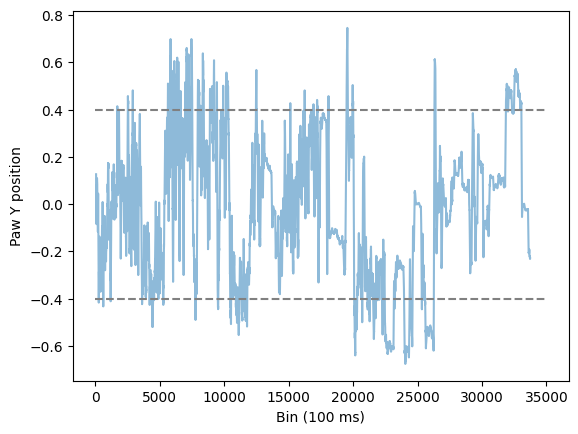

In [ ]:
plt.plot(use_data['left_Y'].rolling(window=50).mean(), alpha=0.5)
# plt.plot(use_data['left_X'].rolling(window=50).mean(), alpha=0.5)
plt.hlines(0.4, 0, 35000, linestyles='--', color='Gray')
plt.hlines(-0.4, 0, 35000, linestyles='--', color='Gray')
#plt.xlim([0, 40000])
plt.xlabel('Bin (100 ms)')
plt.ylabel('Paw Y position')

In [ ]:
df.rolling(window=5).mean()

'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1'

## Fit tau

The rate at which this autocorrelogram declines in a behaving mouse may be characterized as a time-constant, tau, of an exponentially decaying curve. Tau was fit using the Levenberg-Marquardt algorithm (non-linear least squares) using the SciPy optimization package.

In [ ]:
features[var]

'Lick count'

2.2
7.2
3.1
2.7
2.6
7.9
2.8
3.0
3.3
2.9
3.2


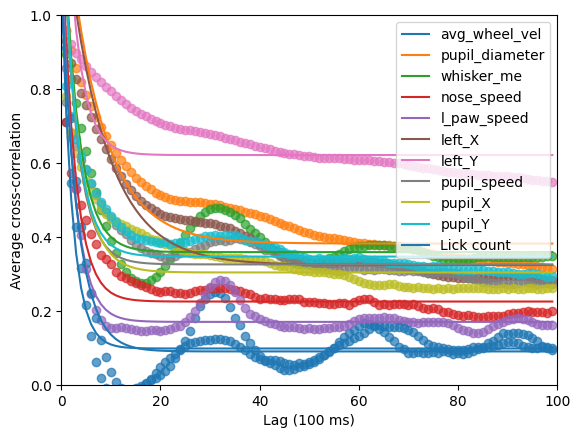

In [ ]:
def func(t, tau, c):
    return np.exp(-t / tau) + c



for v, var in enumerate(range(np.shape(corrs)[0])):
    end = 1000
    t = lags[lags_to_plot:end]
    y = corrs[v, lags_to_plot:end]


    popt, pcov = curve_fit(func, t, y)

    tau, c = popt
    y_fit = func(t, tau, c)
    
    plt.scatter(lags[lags_to_plot:end], y, alpha=0.7)
    plt.plot(lags[lags_to_plot:end], y_fit, label=features[var])
    #plt.legend(str(np.round(tau, decimals=1)))
    plt.legend()
    print(np.round(tau, decimals=1))

    plt.ylim([0, 1])
    plt.xlabel('Lag (100 ms)')
    plt.ylabel('Average cross-correlation')
    plt.xlim([0, lags_to_plot])
    

(0.0, 100.0)

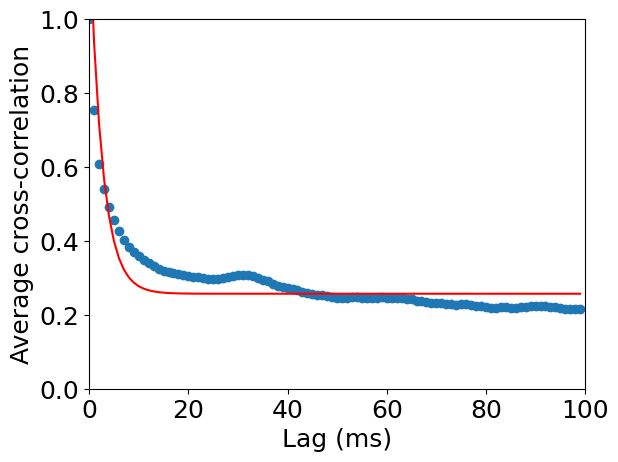

In [ ]:
plt.scatter(lags[100:end], np.mean(corrs, axis=0)[100:end])
plt.plot(lags[100:end], y_fit, color='Red')

plt.ylim([0, 1])
plt.xlabel('Lag (ms)')
plt.ylabel('Average cross-correlation')
plt.xlim([0, 100])


## Trial phase

In [50]:
bins_df = bins_per_trial_phase(design_matrix, session_trials)
bins_df = bins_df.rename(columns={0: 'Bin'})
new_df = design_matrix.merge(bins_df, on='Bin')
melted = pd.melt(new_df, id_vars=['Bin', 'label', 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:410: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:412: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:413: FutureWarning

## Auto-correlation per trial phase

In [51]:
new_df['broader_label'] = new_df['label']
new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

new_df['Lick count'] = gaussian_filter1d(new_df['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
new_df['avg_wheel_vel'] = np.abs(new_df['avg_wheel_vel'])

Stimulus left


ValueError: x and y must have length at least 2.

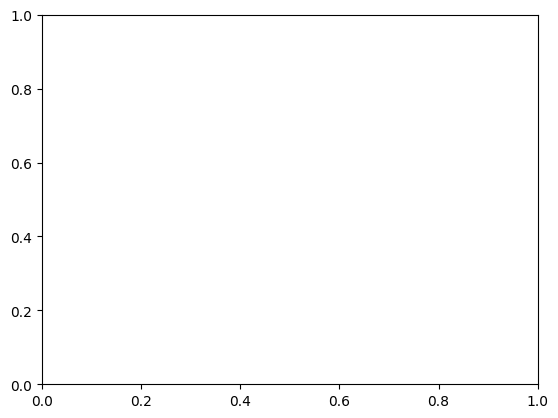

In [63]:
features = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
epoch_type = 'broader_label'
epoch_type = 'label'
trial_epochs = new_df[epoch_type].unique()
lags_to_plot = 100


for e, epoch in enumerate(trial_epochs):
    print(epoch)
    
    fig, ax = plt.subplots()    

    use_data = new_df.loc[new_df[epoch_type]==epoch]
    use_data = use_data[features]

    for i, pc in enumerate(features):
        
        x = use_data[pc]

        # Calculate the lag values corresponding to the cross-correlation
        lags = np.arange(-lags_to_plot, lags_to_plot)

        # Compute the cross-correlation using np.correlate
        cross_correlation = np.zeros(len(lags)) * np.nan
        
        len_timeseries = len(x)
        for l, lag in enumerate(lags):
            if lag < 0:
                x_chunk = np.array(x[-lag:])
                y_chunk = np.array(x[:lag])

            elif lag == 0:
                x_chunk = np.array(x)
                y_chunk = np.array(x)

            elif lag > 0:
                x_chunk = np.array(x[0:-lag])
                y_chunk = np.array(x[lag:])
                
            cross_correlation[l] = stats.pearsonr(x_chunk, y_chunk).statistic
            
        # Save data
        if i == 0:
            corrs = [cross_correlation]
        else:
            corrs = np.vstack((corrs, cross_correlation))
            
        # Plot the cross-correlation once 
        plt.scatter(lags, cross_correlation, label='Raw data', alpha=0.5)
        plt.hlines(0, np.min(lags), np.max(lags), color='gray', linestyles='--')
        plt.vlines(0, -1, 1, color='gray', linestyles='--')
        plt.xlabel('Lag (s)')
        plt.ylabel('Cross-Correlation')
        # ax[i].set_title(pc)
        plt.ylim([-1, 1])
        # ax[i].set_xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])

                    
        plt.tight_layout()
    plt.show()
        
    plt.scatter(lags, np.mean(corrs, axis=0), alpha=0.7, label='Raw data')
    plt.legend()
    plt.ylim([-1.1, 1.1])
    #plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.title(epoch)
    plt.xticks([-100, -50, 0, 50, 100], [-10, -5, 0, 5, 10])
    # Add labels and legend
    plt.xlabel('Time lag (s)')
    #plt.xlim([0, 35])


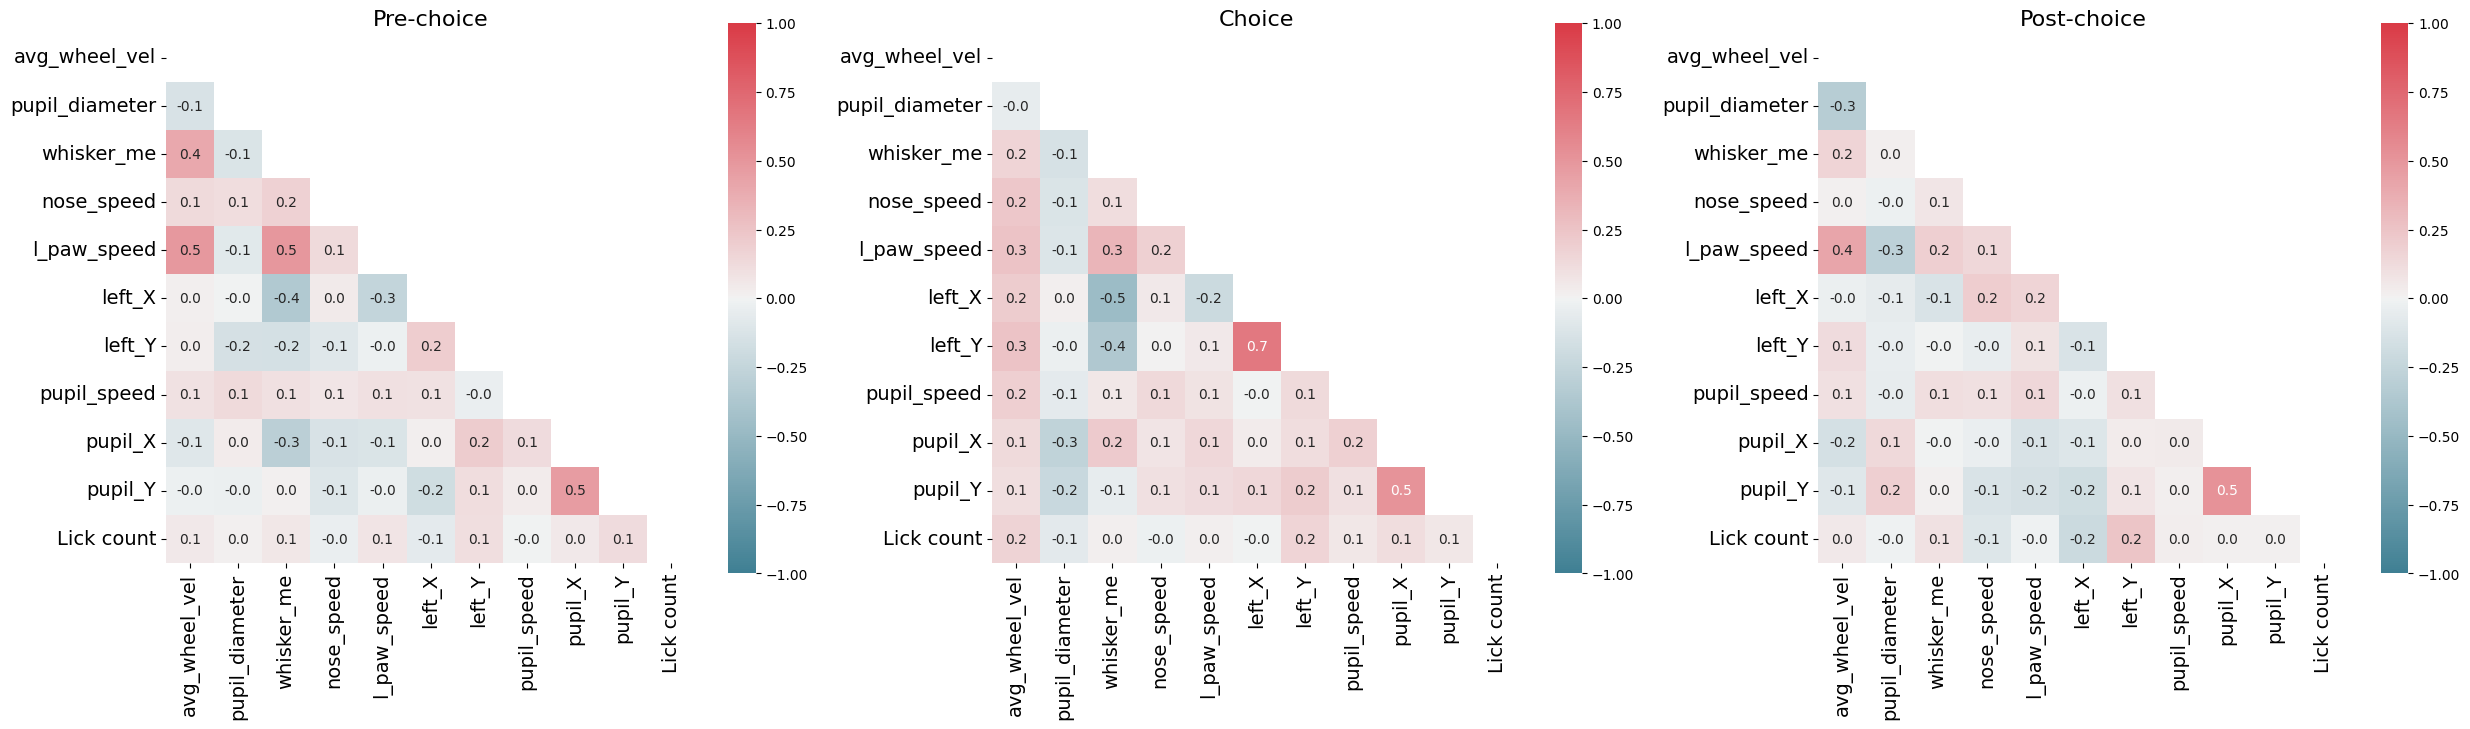

In [55]:
epoch_type = 'broader_label'  # 'broader_label'
trial_epochs = new_df[epoch_type].unique()

fig, ax = plt.subplots(nrows=1, ncols=len(trial_epochs) , sharex=False, sharey=False, figsize=[25, 7])
plt.rc('font', size=10)

for v, epoch in enumerate(trial_epochs):
    
    use_data = new_df.loc[new_df[epoch_type]==epoch]
    cov_df = use_data[var_names].dropna().drop_duplicates()
    cov = cov_df.corr()

    # f = ax[v].figure(figsize=(10, 11))
    ax[v].set_xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
    ax[v].set_yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
    ax[v].set_title(str(epoch), fontsize=16)

    matrix = np.triu(cov)

    sns.heatmap(cov,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0, fmt=".1f",
        square=True, annot=True, mask=matrix, ax=ax[v])

plt.tight_layout()
plt.show()

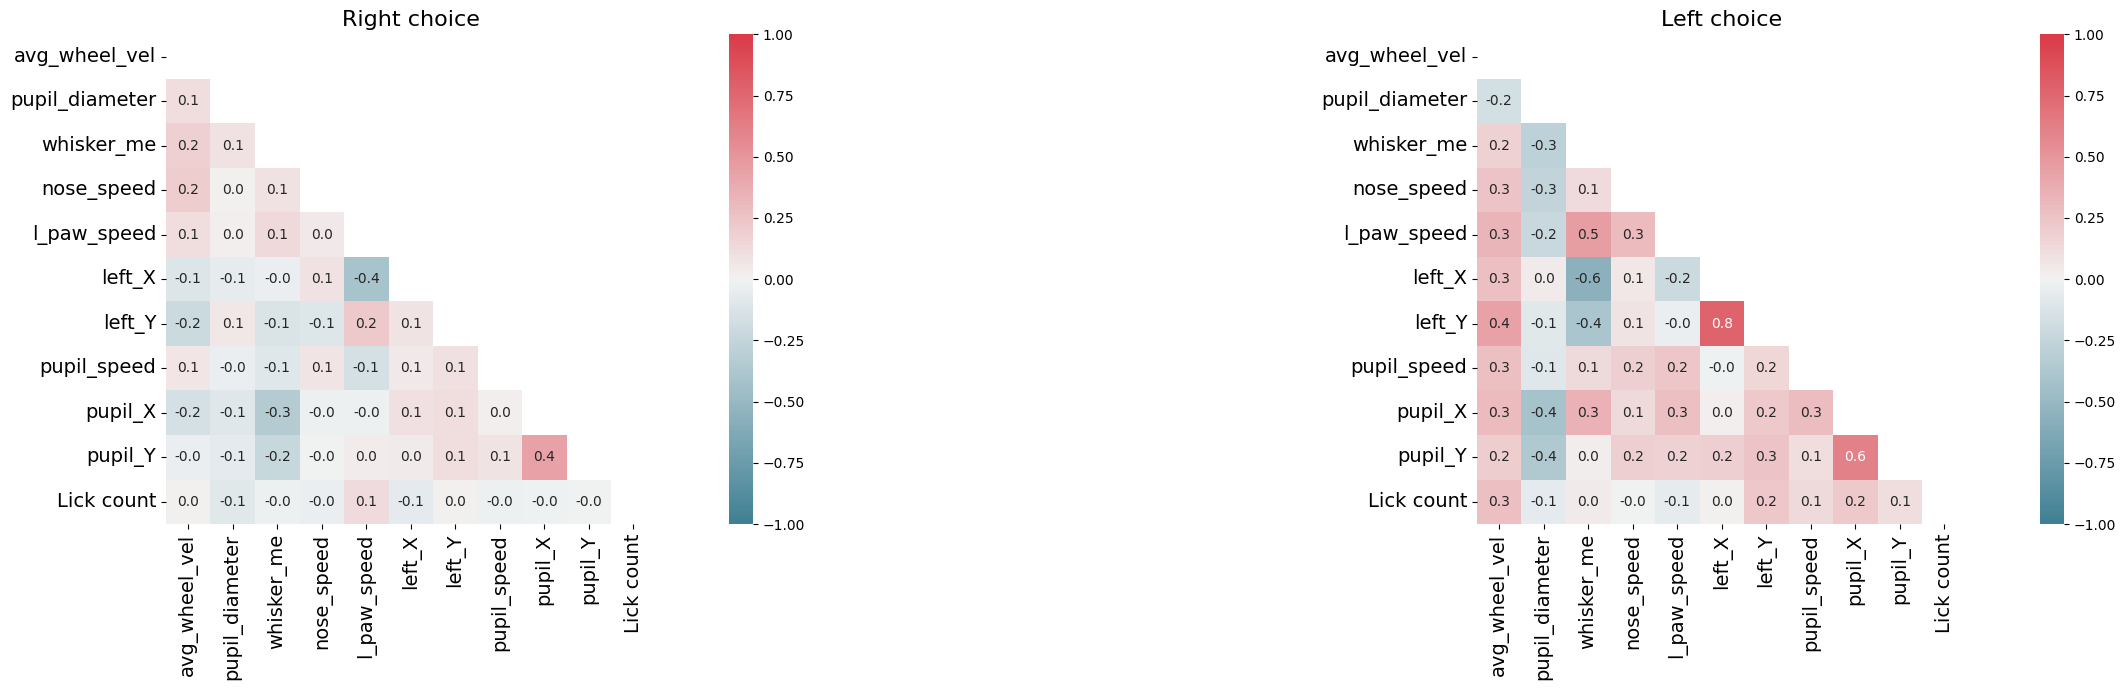

In [59]:
trial_epochs = new_df['label'].unique()
trial_epochs = ['Correct feedback', 'ITI_correct', 'Incorrect feedback', 'ITI_incorrect']
trial_epochs = ['Quiescence', 'Stimulus left', 'Stimulus right']
trial_epochs = ['Right choice', 'Left choice']


fig, ax = plt.subplots(nrows=1, ncols=len(trial_epochs) , sharex=False, sharey=False, figsize=[28, 7])
plt.rc('font', size=10)

for v, epoch in enumerate(trial_epochs):
    
    use_data = new_df.loc[new_df['label']==epoch]
    cov_df = use_data[var_names].dropna().drop_duplicates()
    cov = cov_df.corr()

    # f = ax[v].figure(figsize=(10, 11))
    ax[v].set_xticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14, rotation=45)
    ax[v].set_yticks(range(len(cov_df.keys())), cov_df.columns, fontsize=14)
    ax[v].set_title(str(epoch), fontsize=16)

    matrix = np.triu(cov)

    sns.heatmap(cov,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0, fmt=".1f",
        square=True, annot=True, mask=matrix, ax=ax[v])

plt.tight_layout()
plt.show()